In [6]:
from __future__ import print_function
from keras.applications.vgg16 import preprocess_input, decode_predictions

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [3]:
model = VGG16(weights='imagenet', include_top=True)

In [1]:
model.count_params()

NameError: name 'model' is not defined

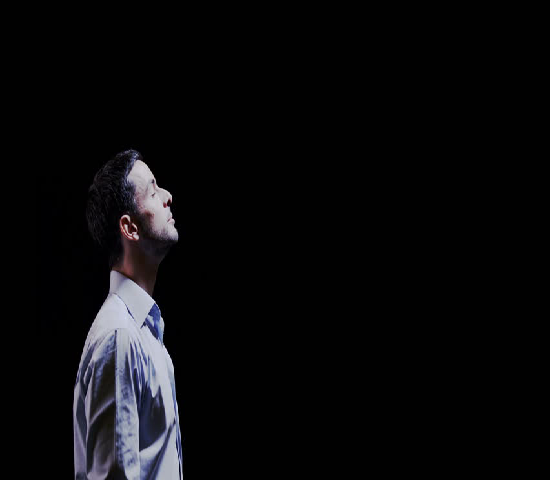

In [55]:

height = 480
width = 550

content_image_path = 'images/person-sky.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

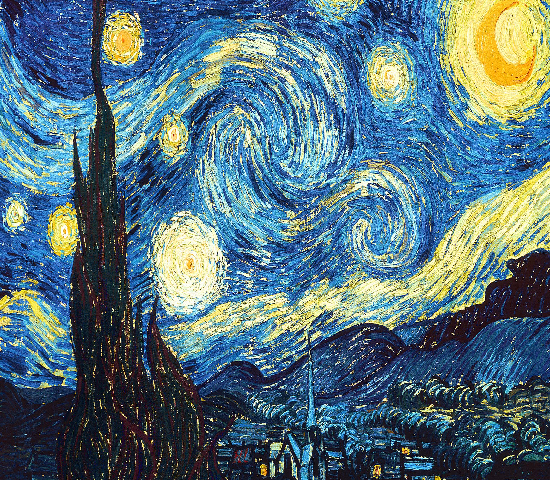

In [56]:
style_image_path = 'images/styles/starry-night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image



In [57]:


content_array = np.asarray(content_image, dtype='float32')  # Convert it into an array
content_array = np.expand_dims(content_array, axis=0)  # Convert it into a list of arrays
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)



# Pre-process the input to match the training data

(1, 480, 550, 3)
(1, 480, 550, 3)


In [58]:
'''
1. Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

'''

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]


In [59]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)

#placeholder variable to store the combination image
combination_image = backend.placeholder((1, height, width, 3))


In [60]:
#concatenate all this image data into a single tensor
input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)

In [61]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False) #We are excluding FC layers and softmax

In [62]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 480, 550, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 480, 550, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 240, 275, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 240, 275, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 240, 275, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 120, 137, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 120, 137, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 120, 137, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 120, 137, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 60, 68, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(3, 60, 68, 51

In [63]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0


In [64]:
loss = backend.variable(0.)

In [65]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss =loss +(  content_weight * content_loss(content_image_features,
                                      combination_features))

In [66]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [67]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [68]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [69]:
grads = backend.gradients(loss, combination_image)


In [70]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 183057120000.0
Iteration 0 completed in 773s
Start of iteration 1
Current loss value: 144465990000.0
Iteration 1 completed in 649s
Start of iteration 2
Current loss value: 134614890000.0
Iteration 2 completed in 608s
Start of iteration 3
Current loss value: 130039440000.0
Iteration 3 completed in 627s
Start of iteration 4


In [35]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')



TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [37]:
image_final = Image.fromarray(x)

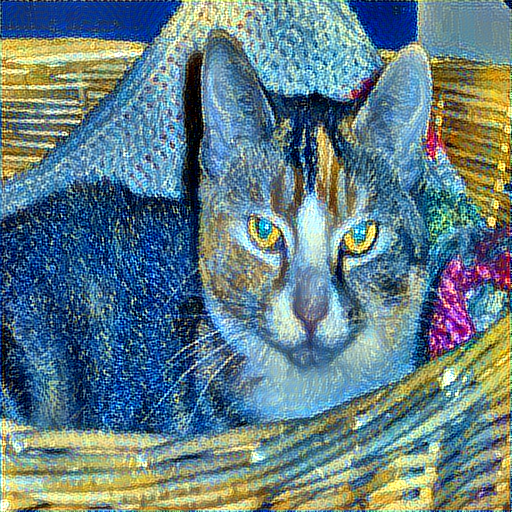

In [38]:
image_final

In [42]:
image_final.save("catvan.jpg")